# MixHop実装

元論文：MixHop: Higher-Order Graph Convolutional Architectures via Sparsified Neighborhood Mixing
Sami Abu-El-Haija, Bryan Perozzi, Amol Kapoor, Nazanin Alipourfard, Kristina Lerman, Hrayr Harutyunyan, Greg Ver Steeg, Aram Galstyan
ICML 2019

https://arxiv.org/abs/1905.00067
参考にしたコード：https://github.com/samihaija/mixhop

全体の流れ

0.   事前にcora.contentとcora.citesをダウンロードして/content/drive/My Drive/Colab Notebooks/に置いてください．
1.   ライブラリのインストール
2.   汎用関数の定義
3.   MixHopモデル定義（複数階の隣接行列を同時使用）
4.   グラフデータ読み込み
5.   学習準備
6.   モデル学習
7.   テスト精度検証
8.   結果の描画


# ライブラリのインストール

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 汎用関数の定義

In [3]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
    #print(edges)

    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    #print(adj)

    adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対象に変更 (つまり，無向グラフに変換)
    #print(adj)

    adj = adj + sparse.eye(adj.shape[0]) #対角成分に1を挿入

    node_degrees = np.array(adj.sum(1)) #列毎の総和を計算する（つまり，次数を計算する）
    #print(node_degrees)

    node_degrees = np.power(node_degrees, -0.5).flatten()
    #print(node_degrees)

    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)
    print(degree_matrix)

    adj = degree_matrix @ adj @ degree_matrix #行列の積を計算．
    #torch.spmm(degree_matrix,torch.spmm(adj,degree_matrix))

    print(adj)

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)
    adj = torch.FloatTensor(np.array(adj.todense()))

    return features, labels, adj, edges

In [5]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE for MixHop")
    plt.show()

# MixHopモデル定義

In [6]:
class MixHopLayer(nn.Module):
    """
    MixHop Layer implementation
    複数階の隣接行列（1-hop, 2-hop, 3-hop）を同時に使用し、
    各hopに対して個別の線形変換を適用してから結合する
    """
    def __init__(self, in_features, out_features_per_hop, hops, dropout):
        super(MixHopLayer, self).__init__()
        self.in_features = in_features
        self.out_features_per_hop = out_features_per_hop
        self.hops = hops  # [1, 2, 3] のようなリスト
        self.dropout = dropout

        # 各hopに対する線形変換層
        self.hop_layers = nn.ModuleList()
        for hop in hops:
            self.hop_layers.append(nn.Linear(in_features, out_features_per_hop))

        # 総出力次元は hop数 × out_features_per_hop
        self.total_out_features = len(hops) * out_features_per_hop

    def forward(self, x, adj):
        # 異なる階数の隣接行列を事前計算
        adj_powers = [adj]  # A^1
        current_adj = adj

        # A^2, A^3, ... を計算
        for i in range(2, max(self.hops) + 1):
            current_adj = torch.mm(current_adj, adj)
            adj_powers.append(current_adj)

        # 各hopに対する特徴量変換
        hop_outputs = []
        for i, hop in enumerate(self.hops):
            # hop階の隣接行列を使用 (hop-1でインデックス調整)
            hop_adj = adj_powers[hop - 1]

            # 隣接行列による特徴量の集約
            aggregated_features = torch.mm(hop_adj, x)

            # 線形変換
            transformed = self.hop_layers[i](aggregated_features)

            # ReLU活性化関数
            activated = F.relu(transformed)

            # Dropout
            dropped = F.dropout(activated, self.dropout, training=self.training)

            hop_outputs.append(dropped)

        # 全hopの出力を結合
        concatenated = torch.cat(hop_outputs, dim=1)

        return concatenated


In [7]:
class MixHop(nn.Module):
    """
    MixHop model implementation
    複数の異なるhop数の隣接行列を同時に使用して特徴量を抽出
    """
    def __init__(self, nfeat, nhid_per_hop, nclass, dropout, hops):
        super(MixHop, self).__init__()
        self.dropout = dropout
        self.hops = hops

        # 最初のMixHopレイヤー
        self.mixhop1 = MixHopLayer(nfeat, nhid_per_hop, hops, dropout)

        # 2層目のMixHopレイヤー（入力次元は前層の出力次元）
        hidden_total = len(hops) * nhid_per_hop
        self.mixhop2 = MixHopLayer(hidden_total, nhid_per_hop, hops, dropout)

        # 最終出力層
        final_input_dim = len(hops) * nhid_per_hop
        self.classifier = nn.Linear(final_input_dim, nclass)

    def forward(self, x, adj):
        # 最初のMixHopレイヤー
        x = self.mixhop1(x, adj)

        # 2番目のMixHopレイヤー
        x = self.mixhop2(x, adj)

        # 最終分類層
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# グラフデータ読み込み

グラフ読み込み

In [8]:
features, labels, adj, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
<DIAgonal sparse matrix of dtype 'float32'
	with 2708 stored elements (1 diagonals) and shape (2708, 2708)>
  Coords	Values
  (0, 0)	0.40824830532073975
  (1, 1)	0.7071067690849304
  (2, 2)	0.4472135901451111
  (3, 3)	0.5
  (4, 4)	0.7071067690849304
  (5, 5)	0.5773502588272095
  (6, 6)	0.5773502588272095
  (7, 7)	0.7071067690849304
  (8, 8)	0.40824830532073975
  (9, 9)	0.4472135901451111
  (10, 10)	0.40824830532073975
  (11, 11)	0.5773502588272095
  (12, 12)	0.5773502588272095
  (13, 13)	0.5
  (14, 14)	0.22360679507255554
  (15, 15)	0.30151134729385376
  (16, 16)	0.4472135901451111
  (17, 17)	0.7071067690849304
  (18, 18)	0.3535533845424652
  (19, 19)	0.5773

In [9]:
print(features)
print(labels)
print(adj)
print(edges)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([5, 3, 1,  ..., 2, 0, 5])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


# 学習準備

In [10]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [11]:
dropout = 0.5  # MixHop用に設定
nhid_per_hop = 16  # 各hopあたりの次元数
hops = [1, 2, 3]  # 1-hop, 2-hop, 3-hopを使用

model = MixHop(nfeat=features.shape[1],
               nhid_per_hop=nhid_per_hop,
               nclass=num_classes,
               dropout=dropout,
               hops=hops)
print(model)

MixHop(
  (mixhop1): MixHopLayer(
    (hop_layers): ModuleList(
      (0-2): 3 x Linear(in_features=1433, out_features=16, bias=True)
    )
  )
  (mixhop2): MixHopLayer(
    (hop_layers): ModuleList(
      (0-2): 3 x Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (classifier): Linear(in_features=48, out_features=7, bias=True)
)


In [12]:
if torch.cuda.is_available(): #cudaが使えるなら，GPUで処理
  model.cuda()
  adj = adj.cuda()
  features = features.cuda()
  labels = labels.cuda()
  print("Using GPU for training")
else:
  print("Using CPU for training")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.NLLLoss()  # log_softmaxの後はNLLLossを使用


Using GPU for training


In [13]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [14]:
print("=== Training MixHop ===")
validation_acc = []
validation_loss = []
training_acc = []
training_loss = []

# Early stopping設定
use_early_stopping = True
patience = 20  # 20エポック待つ
min_delta = 1e-4  # 最小改善量

if use_early_stopping:
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

t_start = time.time()
maxepoch = 300
for epoch in range(maxepoch):
    optimizer.zero_grad()
    model.train()

    y_pred = model(features, adj)
    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    training_loss.append(train_loss.item())
    training_acc.append(train_acc)

    with torch.no_grad():
        model.eval()
        y_pred_val = model(features, adj)  # 評価時は新しく予測
        val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred_val[validation_set], labels[validation_set])

        validation_loss.append(val_loss.item())
        validation_acc.append(val_acc)

        if use_early_stopping:
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    stopped_early = True
                    t_end = time.time()

    if epoch % 20 == 0:  # 20エポック毎に出力
        print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                        f"Train acc: {train_acc:.3f}",
                        f"Val loss: {val_loss.item():.3f}",
                        f"Val acc: {val_acc:.3f}"]))

    if use_early_stopping and stopped_early:
        break

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING condition met. Stopped at epoch: {epoch}.")
else:
    t_end = time.time()

print(f"Total training time: {t_end-t_start:.2f} seconds")

=== Training MixHop ===
Epoch:    0 | Train loss: 1.949 | Train acc: 0.157 | Val loss: 1.939 | Val acc: 0.130
Epoch:   20 | Train loss: 0.368 | Train acc: 0.900 | Val loss: 0.805 | Val acc: 0.770
EARLY STOPPING condition met. Stopped at epoch: 37.
Total training time: 4.44 seconds


# テスト精度の検証

In [15]:
print("=== Test Results (MixHop) ===")
with torch.no_grad():
    model.eval()
    y_pred = model(features, adj)
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"Test loss: {test_loss:.3f}  |  Test acc: {test_acc:.3f}")
print(f"Final Test Accuracy: {test_acc:.3f}")

=== Test Results (MixHop) ===
Test loss: 0.814  |  Test acc: 0.782
Final Test Accuracy: 0.782


# 結果の描画

まずは，訓練データのロスと精度，開発データのロスと精度がエポック毎にどのように変化してるか見てみましょう．

=== Plotting Results ===


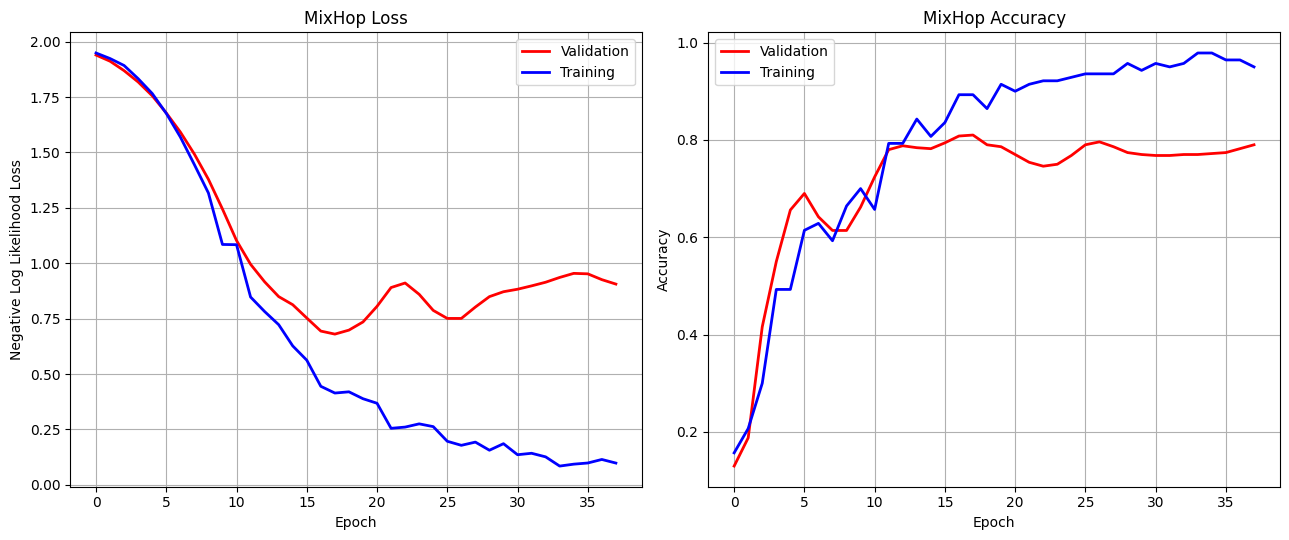

In [16]:
print("=== Plotting Results ===")
f, axs = plt.subplots(1, 2, figsize=(13, 5.5))
axs[0].plot(validation_loss, linewidth=2, color="red", label="Validation")
axs[0].plot(training_loss, linewidth=2, color="blue", label="Training")
axs[0].set_title("MixHop Loss")
axs[0].set_ylabel("Negative Log Likelihood Loss")
axs[0].set_xlabel("Epoch")
axs[0].legend()
axs[0].grid()

# GPU tensorsをCPUに移してからplotting
validation_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in validation_acc]
training_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in training_acc]

axs[1].plot(validation_acc_cpu, linewidth=2, color="red", label="Validation")
axs[1].plot(training_acc_cpu, linewidth=2, color="blue", label="Training")
axs[1].set_title("MixHop Accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

学習後のMixHop特徴表現がラベルごとにかたまっているか見てみましょう．
ここでは，tSNEを用いて多次元データを2次元に落とし込んで可視化をします．

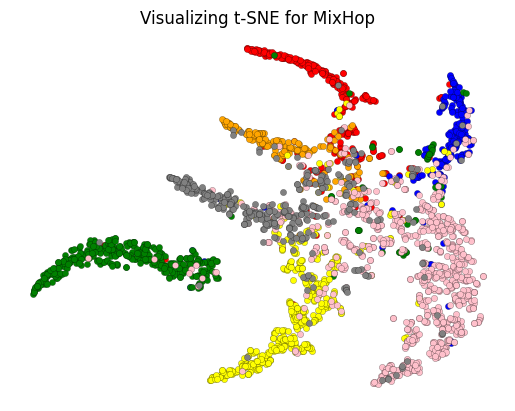

In [17]:
visualize_embedding_tSNE(labels, y_pred, num_classes)